# Keep-it-dry! LightGBM v2

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# from sklearnex import patch_sklearn

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline
from lightgbm import LGBMClassifier
from sklearn.decomposition import PCA

from pprint import pprint

## Dataset Selection

In [8]:
datasets_dict = {}

datasets_dict['ii_mm_adasyn'] = pd.read_csv('./../Preprocessing/kid_train_ii_mm_adasyn.csv', index_col=0)
datasets_dict['ii_mm_ros'] = pd.read_csv('./../Preprocessing/kid_train_ii_mm_ros.csv', index_col=0)
datasets_dict['ii_mm_rus'] = pd.read_csv('./../Preprocessing/kid_train_ii_mm_rus.csv', index_col=0)
datasets_dict['ii_mm_smote'] = pd.read_csv('./../Preprocessing/kid_train_ii_mm_smote.csv', index_col=0)
datasets_dict['ii_mm_smotenc_1'] = pd.read_csv('./../Preprocessing/kid_train_ii_mm_smotenc_1.csv', index_col=0)

datasets_dict['ii_ro_adasyn'] = pd.read_csv('./../Preprocessing/kid_train_ii_ro_adasyn.csv', index_col=0)
datasets_dict['ii_ro_ros'] = pd.read_csv('./../Preprocessing/kid_train_ii_ro_ros.csv', index_col=0)
datasets_dict['ii_ro_rus'] = pd.read_csv('./../Preprocessing/kid_train_ii_ro_rus.csv', index_col=0)
datasets_dict['ii_ro_smote'] = pd.read_csv('./../Preprocessing/kid_train_ii_ro_smote.csv', index_col=0)
datasets_dict['ii_ro_smotenc_1'] = pd.read_csv('./../Preprocessing/kid_train_ii_ro_smotenc_1.csv', index_col=0)

datasets_dict['ii_st_adasyn'] = pd.read_csv('./../Preprocessing/kid_train_ii_st_adasyn.csv', index_col=0)
datasets_dict['ii_st_ros'] = pd.read_csv('./../Preprocessing/kid_train_ii_st_ros.csv', index_col=0)
datasets_dict['ii_st_rus'] = pd.read_csv('./../Preprocessing/kid_train_ii_st_rus.csv', index_col=0)
datasets_dict['ii_st_smote'] = pd.read_csv('./../Preprocessing/kid_train_ii_st_smote.csv', index_col=0)
datasets_dict['ii_st_smotenc_1'] = pd.read_csv('./../Preprocessing/kid_train_ii_st_smotenc_1.csv', index_col=0)

datasets_dict['ki_mm_adasyn'] = pd.read_csv('./../Preprocessing/kid_train_ki_mm_adasyn.csv', index_col=0)
datasets_dict['ki_mm_ros'] = pd.read_csv('./../Preprocessing/kid_train_ki_mm_ros.csv', index_col=0)
datasets_dict['ki_mm_rus'] = pd.read_csv('./../Preprocessing/kid_train_ki_mm_rus.csv', index_col=0)
datasets_dict['ki_mm_smote'] = pd.read_csv('./../Preprocessing/kid_train_ki_mm_smote.csv', index_col=0)
datasets_dict['ki_mm_smotenc_1'] = pd.read_csv('./../Preprocessing/kid_train_ki_mm_smotenc_1.csv', index_col=0)

datasets_dict['ki_ro_adasyn'] = pd.read_csv('./../Preprocessing/kid_train_ki_ro_adasyn.csv', index_col=0)
datasets_dict['ki_ro_ros'] = pd.read_csv('./../Preprocessing/kid_train_ki_ro_ros.csv', index_col=0)
datasets_dict['ki_ro_rus'] = pd.read_csv('./../Preprocessing/kid_train_ki_ro_rus.csv', index_col=0)
datasets_dict['ki_ro_smote'] = pd.read_csv('./../Preprocessing/kid_train_ki_ro_smote.csv', index_col=0)
datasets_dict['ki_ro_smotenc_1'] = pd.read_csv('./../Preprocessing/kid_train_ki_ro_smotenc_1.csv', index_col=0)

datasets_dict['ki_st_adasyn'] = pd.read_csv('./../Preprocessing/kid_train_ki_st_adasyn.csv', index_col=0)
datasets_dict['ki_st_ros'] = pd.read_csv('./../Preprocessing/kid_train_ki_st_ros.csv', index_col=0)
datasets_dict['ki_st_rus'] = pd.read_csv('./../Preprocessing/kid_train_ki_st_rus.csv', index_col=0)
datasets_dict['ki_st_smote'] = pd.read_csv('./../Preprocessing/kid_train_ki_st_smote.csv', index_col=0)
datasets_dict['ki_st_smotenc_1'] = pd.read_csv('./../Preprocessing/kid_train_ki_st_smotenc_1.csv', index_col=0)

[LightGBM] [Info] Number of positive: 16365, number of negative: 16737
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4862
[LightGBM] [Info] Number of data points in the train set: 33102, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494381 -> initscore=-0.022477
[LightGBM] [Info] Start training from score -0.022477
[LightGBM] [Info] Number of positive: 16737, number of negative: 16736
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4177
[LightGBM] [Info] Number of data points in the train set: 33473, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500015 -> initscore=0.000060
[LightGBM] [Info] Start training from score 0.000060
[LightGBM] [In

c:\Users\RAYHAN EGAR\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\RAYHAN EGAR\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\RAYHAN EGAR\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\RAYHAN EGAR\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values

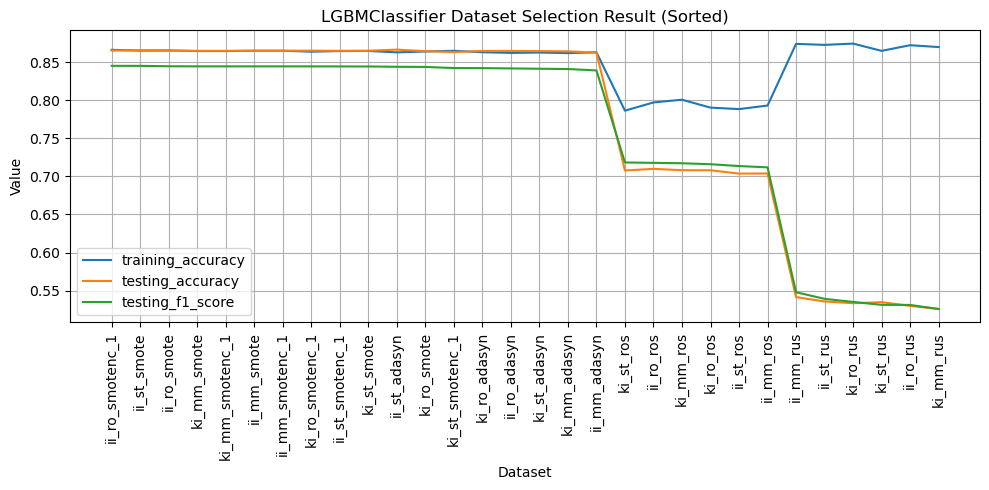

In [9]:
dataset_result = {}
dataset_result['dataset'] = []
dataset_result['training_accuracy'] = []
dataset_result['testing_accuracy'] = []
dataset_result['testing_f1_score'] = []

for title, data in datasets_dict.items():

    X_df = data.copy()
    y_df = X_df.pop('failure')
    object_cols = X_df.select_dtypes(include=['object']).columns
    X_df = X_df.drop(object_cols, axis=1)

    X_train, X_val, y_train, y_val = train_test_split(X_df, y_df, test_size=.2, stratify=y_df, random_state=42)
    
    lgb_dataset = LGBMClassifier()
    lgb_dataset.fit(X_train, y_train)
    
    y_predict = lgb_dataset.predict(X_val)

    dataset_result['dataset'].append(title)
    dataset_result['training_accuracy'].append(lgb_dataset.score(X_train, y_train))
    dataset_result['testing_accuracy'].append(lgb_dataset.score(X_val, y_val))
    dataset_result['testing_f1_score'].append(f1_score(y_val, y_predict))

df_result = pd.DataFrame(dataset_result)
df_result_sorted = df_result.sort_values(by='testing_f1_score', ascending=False)

plt.figure(figsize=[10, 5])

sns.lineplot(data=df_result_sorted, x='dataset', y='training_accuracy', label='training_accuracy').grid(True)
sns.lineplot(data=df_result_sorted, x='dataset', y='testing_accuracy', label='testing_accuracy')
sns.lineplot(data=df_result_sorted, x='dataset', y='testing_f1_score', label='testing_f1_score')

plt.title("LGBMClassifier Dataset Selection Result (Sorted)")
plt.ylabel("Value")
plt.xlabel("Dataset")
plt.xticks(rotation=90)

plt.tight_layout()
plt.legend()
plt.show()

## Data Read

In [26]:
df_train = pd.read_csv('./../Preprocessing/kid_train_ki_mm_rus.csv', index_col=0)
df_test = pd.read_csv('./../Preprocessing/kid_test_ki_mm.csv', index_col=0)

In [27]:
df_train.head()

,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
2506,0.217806,7.0,8.0,9,5,0.275862,0.241379,0.166667,0.694728,0.619632,...,0.567238,0.560581,0.626906,0.514325,0.400321,0.488187,0.417665,0.321893,0.528433,0.0
25459,0.257840,7.0,6.0,6,9,0.310345,0.172414,0.291667,0.624485,0.664110,...,0.584762,0.577151,0.536156,0.421175,0.509346,0.544025,0.372544,0.607726,0.585658,0.0
4562,0.163397,7.0,8.0,9,5,0.586207,0.068966,0.041667,0.541230,0.238438,...,0.370032,0.622150,0.642735,0.487116,0.308297,0.857783,0.601901,0.420760,0.410705,0.0
4352,0.451602,7.0,8.0,9,5,0.379310,0.103448,0.333333,0.649449,0.362671,...,0.569879,0.454773,0.664466,0.732554,0.538104,0.445263,0.474525,0.669145,0.352718,0.0
17021,0.284746,7.0,5.0,6,6,0.275862,0.310345,0.333333,0.303811,0.543181,...,0.477460,0.490195,0.463996,0.531530,0.348642,0.426271,0.420620,0.612728,0.197092,0.0


In [28]:
df_test_id = df_test[['id']]
df_test.drop(columns=['id', 'product_code', 'product_code_F', 'product_code_G', 'product_code_H', 'product_code_I'], inplace=True)
df_test.head()

,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,...,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
0,0.244996,5.0,6.0,6,4,0.206897,0.310345,0.250000,0.708671,0.256017,...,0.400116,0.414603,0.500608,0.425601,0.688620,0.234205,0.583833,0.370388,0.556451,0.392314
1,0.227814,5.0,6.0,6,4,0.379310,0.275862,0.000000,0.519851,0.462364,...,0.483236,0.570794,0.355351,0.446088,0.584667,0.556373,0.574945,0.452963,0.305774,0.304882
2,0.223986,5.0,6.0,6,4,0.275862,0.413793,0.166667,0.598460,0.291765,...,0.297672,0.534095,0.587033,0.426815,0.459347,0.209169,0.501178,0.635761,0.439102,0.414162
3,0.225574,5.0,6.0,6,4,0.275862,0.379310,0.416667,0.338600,0.339783,...,0.434342,0.540063,0.672089,0.280901,0.461428,0.390003,0.495860,0.280786,0.445355,0.356193
4,0.495719,5.0,6.0,6,4,0.482759,0.551724,0.333333,0.509892,0.552737,...,0.456810,0.613714,0.399438,0.408832,0.542093,0.438129,0.535060,0.337007,0.517543,0.541446


In [29]:
# Scale
# Scaled already

In [30]:
X_df = df_train[df_train.columns[:-1]]
y_df = df_train[df_train.columns[-1]]

X_train, X_val, y_train, y_val = train_test_split(X_df, y_df, test_size=.2, random_state=42, stratify=y_df)
X_train.head()

,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,...,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
3345,0.677630,7.0,8.0,9,5,0.344828,0.172414,0.208333,0.542690,0.404908,...,0.635739,0.550984,0.568714,0.443433,0.425976,0.464180,0.456811,0.528590,0.375238,0.639913
20225,0.142274,7.0,5.0,6,6,0.241379,0.517241,0.416667,0.469659,0.335654,...,0.134342,0.560381,0.532989,0.480158,0.371159,0.343568,0.571526,0.522456,0.350518,0.436551
1474,0.237199,7.0,8.0,9,5,0.620690,0.034483,0.083333,0.469260,0.303209,...,0.525029,0.587683,0.440255,0.455270,0.337308,0.339846,0.527539,0.628574,0.380532,0.539897
14802,0.211936,7.0,8.0,5,8,0.275862,0.206897,0.291667,0.416279,0.465078,...,0.488359,0.608762,0.496351,0.441839,0.504481,0.470693,0.580491,0.533860,0.572709,0.523570
25010,0.443692,7.0,6.0,6,9,0.241379,0.206897,0.166667,0.613199,0.325035,...,0.349010,0.592000,0.527744,0.625844,0.560739,0.604669,0.433488,0.605335,0.520948,0.368694


## PCA

In [31]:
n_components_range = range(10, 23)  # Explore components from 10 to 22

best_n_components = None
best_score = -np.inf  # Initialize with a negative infinity

for n_components in n_components_range:
  # Apply PCA with current n_components
  pca = PCA(n_components=n_components)
  pca_data = pca.fit_transform(X_df)

  # Train linearsvc on transformed data
  model = LGBMClassifier()
  model.fit(pca_data, y_df)

  # Evaluate performance on testing set (e.g., using F1 score)
  score = model.score(pca.transform(X_df), y_df)
  print(f"{n_components} components score: {score}")

  # Update best component and score if performance improves
  if score > best_score:
    best_n_components = n_components
    best_score = score

print("Best number of components based on LGBMClassifier performance:", best_n_components)

[LightGBM] [Info] Number of positive: 5649, number of negative: 5649
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 11298, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
10 components score: 0.7881040892193308
[LightGBM] [Info] Number of positive: 5649, number of negative: 5649
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 11298, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
11 components score: 0.8051867587183572
[LightGBM] [Info] Number of positive: 5649, nu

In [32]:
pca = PCA(n_components=22)
X_df_pca = pca.fit_transform(X_df)
df_test_pca = pca.transform(df_test)

## Hyperparameter Tuning using GridSearchCV

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X_df_pca, y_df, test_size=.2, random_state=42, stratify=y_df)

In [34]:
# Define model
model = LGBMClassifier(n_estimators=100) 

# Define hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 1.0],
    'num_leaves': [2**i for i in range(4, 8)],  # Adjust range for num_leaves
    'reg_alpha': [0.0, 0.1, 1.0],  # L1 regularization
    'reg_lambda': [0.0, 0.1, 1.0]   # L2 regularization
}

# Define GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='roc_auc')  # Use F1 score for imbalanced data

In [35]:
# GridSearchCV fitting
grid_search.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 3615, number of negative: 3615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5610
[LightGBM] [Info] Number of data points in the train set: 7230, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 3615, number of negative: 3615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5610
[LightGBM] [Info] Number of data points in the train set: 7230, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 3615, number of negative: 3615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, t

GridSearchCV(cv=5, estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 1.0],
                         'num_leaves': [16, 32, 64, 128],
                         'reg_alpha': [0.0, 0.1, 1.0],
                         'reg_lambda': [0.0, 0.1, 1.0]},
             scoring='roc_auc')

In [36]:
lgbm_best = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best f1-score: {grid_search.best_score_}")

Best parameters: {'learning_rate': 0.01, 'num_leaves': 16, 'reg_alpha': 0.0, 'reg_lambda': 0.0}
Best f1-score: 0.5744919148886071


Previously with scoring='f1'
- Best parameters: {'learning_rate': 1.0, 'num_leaves': 128, 'reg_alpha': 0.0, 'reg_lambda': 0.0}
- Best f1-score: 0.8780270115765625

## Prediction

In [37]:
y_pred = lgbm_best.predict(df_test_pca)
y_pred_df = pd.DataFrame(y_pred, columns=['failure'])

In [38]:
y_submission = pd.concat([df_test_id, y_pred_df], axis=1)

In [39]:
y_submission.head()

,id,failure
0,26570,1.0
1,26571,0.0
2,26572,0.0
3,26573,0.0
4,26574,1.0


In [40]:
y_submission.to_csv('./../Submission/kid_submission_lgbm_latesub_v2.csv', index=False)